In [43]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [21]:
using DelimitedFiles

function read_matrix(filename::String)
    """
    Reads a distance matrix from a file into a Julia array.
    
    Args:
        filename (String): The path to the file containing the distance matrix.
        
    Returns:
        Array{Int64, 2}: The distance matrix as a Julia array.
    """
    return readdlm(filename, ' ', Int)
end

# Example usage
D = read_matrix("TSPs/test.tsp")
println("Read matrix from file:")
D


Read matrix from file:


10×10 Matrix{Int64}:
  0  42  67  19  47  36  68  96  96  86
 89   0  72  23  29  56  93  92  14  56
 12  87   0  60  36  67  39  53  71  55
 51  82  50   0  60  93  28   4  71  51
 69   9  47  12   0  37  31  17  82  74
 15  99   7  98  98   0  18  57  27  43
 26  27  78  11  43  28   0  49  28  58
 39  86   1  99  87  47  18   0  91  55
 69  49  23  78  11  25  92  91   0  45
 39  23  13   8  92  38  82  46  65   0

In [22]:
function cycle_graph_adjacency_matrix(n::Int, directed::Bool=true)
    """
    Generates the adjacency matrix of a cycle graph of length n.

    Args:
        n (Int): The number of nodes in the cycle graph.
        directed (Bool): If true, generates a directed cycle graph.
                         If false, generates an undirected cycle graph.

    Returns:
        Array{Int64, 2}: The adjacency matrix of the cycle graph.
    """
    # Initialize an n x n matrix with zeros
    adj_matrix = zeros(Int, n, n)
    
    if directed
        # Directed cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
        end
        adj_matrix[n, 1] = 1  # Last node connects to the first node
    else
        # Undirected cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
            adj_matrix[i+1, i] = 1
        end
        adj_matrix[n, 1] = 1
        adj_matrix[1, n] = 1  # Last node connects to the first node and vice versa
    end
    
    return adj_matrix
end

# Example usage
n = 10
directed = false  # Set to false for undirected
T = cycle_graph_adjacency_matrix(n, directed)
println("Adjacency matrix for cycle graph of length $n (directed=$directed):")
T


Adjacency matrix for cycle graph of length 10 (directed=false):


10×10 Matrix{Int64}:
 0  1  0  0  0  0  0  0  0  1
 1  0  1  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0
 0  0  1  0  1  0  0  0  0  0
 0  0  0  1  0  1  0  0  0  0
 0  0  0  0  1  0  1  0  0  0
 0  0  0  0  0  1  0  1  0  0
 0  0  0  0  0  0  1  0  1  0
 0  0  0  0  0  0  0  1  0  1
 1  0  0  0  0  0  0  0  1  0

# Manopt tests

In [2]:
n = 100
σ = π / 8
M = Sphere(2)
p = 1 / sqrt(2) * [1.0, 0.0, 1.0]
data = [exp(M, p,  σ * rand(M; vector_at=p)) for i in 1:n];

In [3]:
f(M, p) = sum(1 / (2 * n) * distance.(Ref(M), Ref(p), data) .^ 2)
grad_f(M, p) = sum(1 / n * grad_distance.(Ref(M), data, Ref(p)));

In [11]:
p = [1.0, 0.0, 0.0]

3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [12]:
grad_f(M, p)

3-element Vector{Float64}:
 -0.0
 -0.03192823214756772
 -0.7304767853686407

The gradient added to the point does not stay in the manifold

In [13]:
norm(p + grad_f(M, p))

1.238796087324533

The retracted point does 

In [14]:
q = retract(M, x, grad_f(M, x))

3-element Vector{Float64}:
  0.7443908344118958
 -0.029158428168731446
 -0.6671072415363892

In [15]:
norm(q)

0.9999999999999999

Riemannian gradient descent (cannot be modified by additional dynamic terms)

In [6]:
m1 = gradient_descent(M, f, grad_f, data[1])

3-element Vector{Float64}:
 0.7205741174567424
 0.03508569648410223
 0.6924896642937467

In [7]:
m2 = gradient_descent(M, f, grad_f, data[1];
    debug=[:Iteration,(:Change, "|Δp|: %1.9f |"),
        (:Cost, " F(x): %1.11f | "), "\n", :Stop],
    stopping_criterion = StopAfterIteration(6)
  )

Initial  F(x): 0.14628685032 | 
# 1     |Δp|: 0.338354292 | F(x): 0.13941314756 | 
# 2     |Δp|: 0.263215108 | F(x): 0.13526008046 | 
# 3     |Δp|: 0.204816724 | F(x): 0.13274542973 | 
# 4     |Δp|: 0.159390175 | F(x): 0.13122382386 | 
# 5     |Δp|: 0.124055516 | F(x): 0.13030202930 | 
# 6     |Δp|: 0.096558669 | F(x): 0.12974385430 | 
The algorithm reached its maximal number of iterations (6).


3-element Vector{Float64}:
 0.657338169421013
 0.07190642040832436
 0.7501573153187888

## Orthogonal matrices

In [30]:
M₀ = OrthogonalMatrices(10)

OrthogonalMatrices(10)

Cost function

In [27]:
cost_fnc(P) = tr(transpose(D)*transpose(P)*T*P)

cost_fnc (generic function with 1 method)

In [34]:
cost_fnc(rand(M₀))

502.16643754401645

## Dynamics over manifold

$\nabla F (P) = P \left[ \left\{ P^T T P, D  \right\} + \left\{ P^T T^T P, D^T  \right\} \right]$

In [ ]:
# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A

# Right hand side of the dif
function basic_rule!(du, u, params, t)
    D = params[1]
    T = params[2]
    # N = ... the dimension of D, T and P

    # P = ... somehow get P from u

    for i in 1:N*N
        # Update for each element using the rule.
        # du[i] = ... somehow put d/dt P into du
    end
end

In [48]:
M₀ = OrthogonalMatrices(10)

# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A

# Right hand side of the dif
function basic_rule!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    P = reshape(u, N, N)

    # Compute the Lie brackets
    bracket1 = ⊖(transpose(P) * T * P, D)
    bracket2 = ⊖(transpose(P) * transpose(T) * P, transpose(D))
 
    # Compute the update rule
    dP_dt = P * (bracket1 + bracket2)

    # Convert the matrix dP_dt to a vector
    du[:] = vec(dP_dt)  # Flatten the matrix into a vector
end

# define problem and run simulation
params = (D, T)     # (p, a, b, N, J)
tspan = (0.0,1.5)

# initial condition(s)
P0 = rand(M₀) # This is P(t=0)
u0 = vec(P0) # somehow encode the matrix rand(M₀) into a vector  


#p, beta, alpha, N J
prob = ODEProblem(basic_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

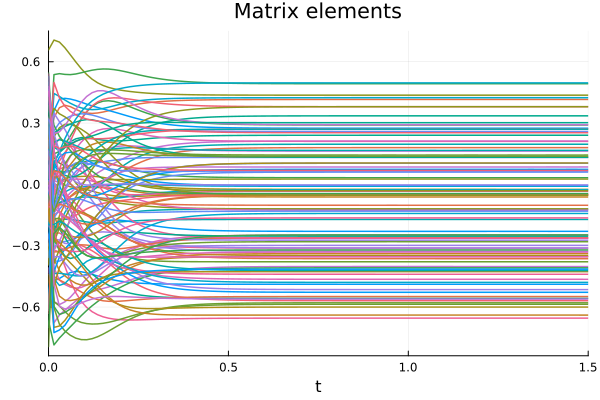

In [49]:
plot(sol, idxs=1:100, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

In [57]:
Manifolds.is_point(M₀, reshape(sol.u[3], 10, 10))

false

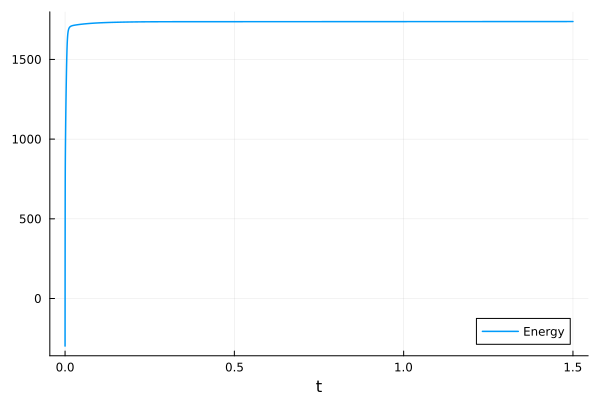

In [51]:
plot(sol.t,[ cost_fnc(reshape(x_t, 10, 10)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t")